In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
from __future__ import print_function

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from deepviz.guided_backprop import GuidedBackprop
# from sklearn.cross_validation import train_test_split
from sklearn.metrics.ranking import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from deepviz.guided_backprop import GuidedBackprop

try:
    import keras

    import keras.backend as K
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import RMSprop
    from keras.optimizers import Adam
    from keras.optimizers import Adagrad
    from keras.optimizers import SGD
    from keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint
    from keras.layers.core import Lambda
    from keras.losses import categorical_crossentropy
    import tensorflow as tf
    from keras import regularizers

except:
    print("Keras not found")
    
np.random.seed(42)


def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/github_trait_geo_diverse_dl/trait-geo-diverse-dl'

651
811
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 50)                2100      
_________________________________________________________________
dense_77 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_78 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_79 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_80 (Dense)             (None, 2)                 52        
_________________________________________________________________
activation_16 (Activation)   (None, 2)                 0         
Total params: 4,727
Trainable params: 4,727
Non-trainable params: 0
_________________________________________________________________


1242/1242 [==============================] - 0s 23us/step - loss: 0.2123 - acc: 0.9412 - val_loss: 0.6203 - val_acc: 0.8136
Epoch 53/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.2183 - acc: 0.9412 - val_loss: 0.6640 - val_acc: 0.8000
Epoch 54/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.2286 - acc: 0.9356 - val_loss: 0.6517 - val_acc: 0.8000
Epoch 55/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.2053 - acc: 0.9444 - val_loss: 0.5990 - val_acc: 0.8182
Epoch 56/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.1989 - acc: 0.9493 - val_loss: 0.6446 - val_acc: 0.8045
Epoch 57/500
1242/1242 [==============================] - 0s 24us/step - loss: 0.1956 - acc: 0.9485 - val_loss: 0.6624 - val_acc: 0.8045
Epoch 58/500
1242/1242 [==============================] - 0s 24us/step - loss: 0.1920 - acc: 0.9533 - val_loss: 0.6719 - val_acc: 0.8136
Epoch 59/500
1242/1242 [==============================

Epoch 112/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1314 - acc: 0.9750 - val_loss: 1.1724 - val_acc: 0.7864
Epoch 113/500
1242/1242 [==============================] - 0s 21us/step - loss: 0.1241 - acc: 0.9750 - val_loss: 1.0652 - val_acc: 0.7955
Epoch 114/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1231 - acc: 0.9831 - val_loss: 1.1383 - val_acc: 0.7864
Epoch 115/500
1242/1242 [==============================] - 0s 25us/step - loss: 0.1647 - acc: 0.9670 - val_loss: 1.1785 - val_acc: 0.7864
Epoch 116/500
1242/1242 [==============================] - 0s 24us/step - loss: 0.1536 - acc: 0.9638 - val_loss: 1.1809 - val_acc: 0.7591
Epoch 117/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1436 - acc: 0.9622 - val_loss: 1.1316 - val_acc: 0.7773
Epoch 118/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1247 - acc: 0.9742 - val_loss: 1.1104 - val_acc: 0.8000
Epoch 119/500
1242/1242 [=========

1242/1242 [==============================] - 0s 22us/step - loss: 0.0852 - acc: 0.9952 - val_loss: 1.5006 - val_acc: 0.7636
Epoch 172/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0835 - acc: 0.9952 - val_loss: 1.4930 - val_acc: 0.7818
Epoch 173/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0942 - acc: 0.9928 - val_loss: 1.5252 - val_acc: 0.7636
Epoch 174/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.1307 - acc: 0.9887 - val_loss: 1.4868 - val_acc: 0.7591
Epoch 175/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.1274 - acc: 0.9839 - val_loss: 1.6243 - val_acc: 0.7591
Epoch 176/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1079 - acc: 0.9863 - val_loss: 1.4618 - val_acc: 0.7818
Epoch 177/500
1242/1242 [==============================] - 0s 21us/step - loss: 0.1169 - acc: 0.9839 - val_loss: 1.7055 - val_acc: 0.7500
Epoch 178/500
1242/1242 [=======================

1242/1242 [==============================] - 0s 23us/step - loss: 0.0749 - acc: 0.9968 - val_loss: 1.6223 - val_acc: 0.7864
Epoch 231/500
1242/1242 [==============================] - 0s 25us/step - loss: 0.0745 - acc: 0.9976 - val_loss: 1.6393 - val_acc: 0.7773
Epoch 232/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0750 - acc: 0.9976 - val_loss: 1.6340 - val_acc: 0.7682
Epoch 233/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0733 - acc: 0.9976 - val_loss: 1.6006 - val_acc: 0.7864
Epoch 234/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0724 - acc: 0.9976 - val_loss: 1.6311 - val_acc: 0.7682
Epoch 235/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0747 - acc: 0.9976 - val_loss: 1.6633 - val_acc: 0.7818
Epoch 236/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0744 - acc: 0.9960 - val_loss: 1.6420 - val_acc: 0.7773
Epoch 237/500
1242/1242 [=======================

1242/1242 [==============================] - 0s 23us/step - loss: 0.0716 - acc: 0.9976 - val_loss: 1.6542 - val_acc: 0.7864
Epoch 290/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0702 - acc: 0.9984 - val_loss: 1.6331 - val_acc: 0.7727
Epoch 291/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0717 - acc: 0.9976 - val_loss: 1.6604 - val_acc: 0.7909
Epoch 292/500
1242/1242 [==============================] - 0s 25us/step - loss: 0.0721 - acc: 0.9952 - val_loss: 1.6644 - val_acc: 0.7909
Epoch 293/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0716 - acc: 0.9984 - val_loss: 1.6376 - val_acc: 0.7682
Epoch 294/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0716 - acc: 0.9976 - val_loss: 1.6681 - val_acc: 0.7864
Epoch 295/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0722 - acc: 0.9976 - val_loss: 1.6422 - val_acc: 0.7864
Epoch 296/500
1242/1242 [=======================

1242/1242 [==============================] - 0s 24us/step - loss: 0.0755 - acc: 0.9960 - val_loss: 1.6467 - val_acc: 0.7682
Epoch 349/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0710 - acc: 0.9976 - val_loss: 1.7159 - val_acc: 0.7773
Epoch 350/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0851 - acc: 0.9952 - val_loss: 1.7005 - val_acc: 0.7727
Epoch 351/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0863 - acc: 0.9911 - val_loss: 1.7294 - val_acc: 0.7682
Epoch 352/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1014 - acc: 0.9863 - val_loss: 1.6126 - val_acc: 0.7636
Epoch 353/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.1042 - acc: 0.9879 - val_loss: 1.7070 - val_acc: 0.7636
Epoch 354/500
1242/1242 [==============================] - 0s 24us/step - loss: 0.0888 - acc: 0.9903 - val_loss: 1.7090 - val_acc: 0.7591
Epoch 355/500
1242/1242 [=======================

1242/1242 [==============================] - 0s 23us/step - loss: 0.0677 - acc: 0.9984 - val_loss: 1.7257 - val_acc: 0.7591
Epoch 408/500
1242/1242 [==============================] - 0s 25us/step - loss: 0.0671 - acc: 0.9984 - val_loss: 1.7572 - val_acc: 0.7545
Epoch 409/500
1242/1242 [==============================] - 0s 26us/step - loss: 0.0683 - acc: 0.9968 - val_loss: 1.7386 - val_acc: 0.7636
Epoch 410/500
1242/1242 [==============================] - 0s 25us/step - loss: 0.0691 - acc: 0.9960 - val_loss: 1.7468 - val_acc: 0.7636
Epoch 411/500
1242/1242 [==============================] - 0s 24us/step - loss: 0.0677 - acc: 0.9976 - val_loss: 1.7310 - val_acc: 0.7636
Epoch 412/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0662 - acc: 0.9976 - val_loss: 1.7516 - val_acc: 0.7682
Epoch 413/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0663 - acc: 0.9984 - val_loss: 1.7547 - val_acc: 0.7591
Epoch 414/500
1242/1242 [=======================

1242/1242 [==============================] - 0s 25us/step - loss: 0.0674 - acc: 0.9976 - val_loss: 1.8706 - val_acc: 0.7636
Epoch 467/500
1242/1242 [==============================] - 0s 28us/step - loss: 0.0668 - acc: 0.9976 - val_loss: 1.8068 - val_acc: 0.7682
Epoch 468/500
1242/1242 [==============================] - 0s 27us/step - loss: 0.0649 - acc: 0.9984 - val_loss: 1.8274 - val_acc: 0.7591
Epoch 469/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0653 - acc: 0.9968 - val_loss: 1.8654 - val_acc: 0.7727
Epoch 470/500
1242/1242 [==============================] - 0s 27us/step - loss: 0.0657 - acc: 0.9984 - val_loss: 1.8364 - val_acc: 0.7591
Epoch 471/500
1242/1242 [==============================] - 0s 22us/step - loss: 0.0656 - acc: 0.9976 - val_loss: 1.8251 - val_acc: 0.7682
Epoch 472/500
1242/1242 [==============================] - 0s 23us/step - loss: 0.0635 - acc: 0.9984 - val_loss: 1.8366 - val_acc: 0.7591
Epoch 473/500
1242/1242 [=======================

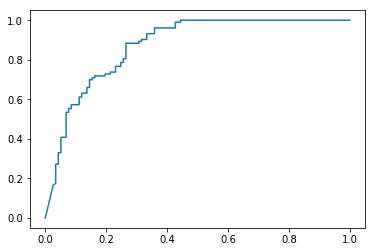

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
(220, 41)
Precipitation_Warmest_Quarter
['PET_Seasonality' 'Isothermality' 'Precipitation_Coldest_Quarter'
 'Precipitation_Seasonality' 'Aridity_Index_Thornthwaite'
 'PET_Driest_Quarter' 'Max_Temp_Coldest' 'Precipitation_Wettest_Month'
 'Mean_Temp_Wettest_Quarter' 'Precipitation_Wettest_Quarter'
 'Mean_Temp_Coldest_Quarter' 'Organic_Carbon' 'PhCaCL'
 'Temperature_Seasonality' 'Aspect' 'Temp_Annual_Range'
 'Mean_Temp_Driest_Quarter' 'Moisture_Index' 'Bulk_Density' 'Emberger_Q'
 'Growing_Deg_Days5' 'Max_Temp_Warmest_Month' 'Slope'
 'Annual_Mean_Temperature' 'PET_Warmest_Quarter' 'Min_Temp_Warmest'
 'Annual_Precipitation' 'Month_Count_by_Temp' 'Min_Temp_Coldest_Month'
 'Thermicity_Index' 'Mean_Temp_Warmest_Quarter' 'Annual_PET'
 'Clay_Percentage' 'PET_Wettest_Quarter' 'Precipitation_Driest_Month'
 'Continentality' 'Growing_Deg_Days0' 'PET_Coldest_Quarter'
 'Precipitation_Driest_Quarter' 'Mean_Diurnal_Temp_Range'
 'Precipi

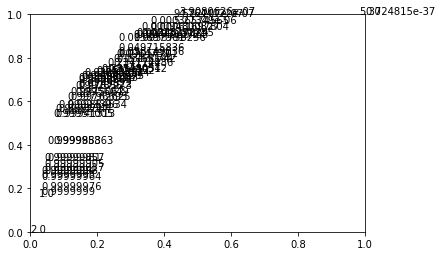

In [31]:
def main():
    table = pd.read_csv(file_dir +"/data/capriolus_trial/Capriolus_capriolus_env_dataframe.csv")
    table =table.loc[:1500]
    # at 40 degrees latitude
    bin_size_km = 5
    one_degree_latitude_km = 111.03  # http://www.longitudestore.com/how-big-is-one-gps-degree.html
    one_degree_longitude_km = 85.39
    step_latitude = 1. / one_degree_latitude_km * bin_size_km
    step_longitude = 1. / one_degree_longitude_km * bin_size_km
    # print("step_latitude, step_longitude", step_latitude, step_longitude)

    # remove spaces from column names
    for column in table.columns:
        table[column.strip()] = table[column]
        if column.strip() != column:
            del table[column]
    # print(table.columns)
    # print(table.decimal_latitude.min(), table.decimal_latitude.max())

    latitude_min = table.decimal_latitude.min()
    longitude_min = table.decimal_longitude.min()
    table.decimal_latitude = table.decimal_latitude.apply(lambda x: (x - latitude_min) // step_latitude)
    table.decimal_longitude = table.decimal_longitude.apply(lambda x: (x - longitude_min) // step_longitude)
    table.decimal_latitude = table.decimal_latitude.astype(int)
    table.decimal_longitude = table.decimal_longitude.astype(int)

    # make feature vector
    band_columns = [column for column in table.columns[8:]]
    X = []
    y = []
    for _, row in table.iterrows():
        x = row[band_columns].values
        if (np.any(x <= -9999.0)):  # in sea?
            continue
        # print(row["present/pseudo_absent"], np.where(x <= -9999.0)[0])
        x = x.tolist()
        x.append(row["present/pseudo_absent"])
        X.append(x)

    df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
    df.to_csv("filtered.csv", index=None)

    print(len(df[df["presence" ]==1]))
    print(len(df[df["presence" ]==0]))

    # Scale feature values
    for column in df.columns[:-1]:
        # if "band" in column:
        std_dev = np.std(df[column])
        mean_ = np.mean(df[column])
        df[column] = df[column].apply(lambda x: (x - mean_) / std_dev)
    df.to_csv("normalized.csv", index=None)

    X = []
    y = []
    band_columns = [column for column in df.columns[:-1]]
    # print(band_columns)

    for _, row in df.iterrows():
        X.append(row[band_columns].values.tolist())
        y.append([1 - row["presence"], row["presence"]])

    X = np.vstack(X)
    y = np.vstack(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    batch_size = 100
    num_classes = 2
    epochs = 500
    
    num_inputs = X.shape[1]  # number of features

    #reducelr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8,
     #                                     verbose=1)
    
    model = Sequential()
    layer_1 = Dense(50, activation='relu',input_shape=(num_inputs,), kernel_regularizer=regularizers.l1(0.0001))

    layer_2 = Dense(25, activation='relu', input_shape=(num_inputs,), kernel_regularizer=regularizers.l1(0.0001))
    layer_3 = Dense(25, activation='relu', input_shape=(num_inputs,), kernel_regularizer=regularizers.l1(0.0001))
    layer_4 = Dense(25, activation='relu', input_shape=(num_inputs,), kernel_regularizer=regularizers.l1(0.0001))
    
    
    model.add(layer_1)
   # model.add(Dropout(0.5))
    model.add(layer_2)
    #model.add(Dropout(0.5))
    model.add(layer_3)
    #model.add(Dropout(0.5))
    model.add(layer_4)
    #model.add(Dropout(0.5))
  
    
    
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    # model.add(Dense(512, activation='relu',
    #             # kernel_regularizer=regularizers.l2(0.01),
    #             # activity_regularizer=regularizers.l1(0.01)
    #                 ))
    # model.add(Dropout(0.5))
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    out_layer = Dense(num_classes, activation=None)
    model.add(out_layer)
    model.add(Activation("softmax"))

    model.summary()

    model.compile(loss="categorical_crossentropy",
                # optimizer =SGD(lr=0.001, momentum =0.9, nesterov=True),
                # optimizer=Adagrad(lr=0.001),
                # optimizer=RMSprop(lr=0.001),# rho=0.9, epsilon=1e-08, decay=0.0),
                optimizer=Adam(lr=0.001),#, rho=0.9, epsilon=1e-08, decay=0.0),
                metrics =['accuracy'])

    history = model.fit(X_train, y_train,
    batch_size =batch_size,
    epochs =epochs,
    verbose =1,
    validation_data =(X_test, y_test),
    callbacks =[],
    shuffle =True,
    class_weight ={
        0: 1,
        1: 1,
    }
    )

    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    predictions = model.predict(X_test)
    print("AUC", roc_auc_score(y_test[:, 1], predictions[:, 1]))
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
    plt.plot(fpr, tpr)
    plt.show()
    
    guided_bprop = GuidedBackprop(model)
    #mask = guided_bprop.get_mask(X_test[0])
    masks = []
    for i in range(X_test.shape[0]):
        masks.append(guided_bprop.get_mask(X_test[i]))
        #print(masks[-1].shape)
    print(np.vstack(masks).shape)
    mask = np.mean(np.vstack(masks), axis=0)
    print(band_columns[mask.argmax()])
    print(np.array(band_columns)[mask.argsort()])
    
    for i, xy in enumerate(zip(fpr, tpr)):
        plt.gca().annotate(str(thresholds[i]), xy=xy, textcoords='data')

    plt.show()


if __name__ == "__main__":
    main()


